In [21]:
## IMPORTAMOS LAS LIBRERIAS PARA EL MANEJO DEL SISTEMA SLIT, REDES NEURONALES Y SISTEMAS MATEMATICOS
#sys.path.append('D:/projects/base/app/modules') 
## RAZONAMIENTO MATEMATICO######################
import numpy as np
from scipy.signal import lti 
from scipy import stats
from scipy.stats import expon
import scipy.fftpack as fourier
from scipy.fftpack import fft, fftfreq, fftshift
import seaborn as sns ## LIBRERIA PARA HISTOGRAMA 
from numpy import logspace
import sympy as sym
##################################################


##### GRAFICACIÓN#######################
import matplotlib.pyplot as plt
########################################


##MANEJO DEL CIRCUITO###########################
from lcapy import Circuit, j, omega, s
################################################


####################REDES_NEURONALES#####################
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
########################################################


##################LIBRERIAS PROPIAS########################
import import_ipynb
#import A
from Librerias_Señales.Libreria_fourier import *

###########################################################


In [22]:
########### CONTRUIMOS EL CIRCUITO##########################:

ctt=Circuit("""
Vi 1 0_1 step;down
C1 1 2; right, size=1.5
R1 2 0; down, size=1.5
C2 2 3; right
R3 2 3; right, offset=0.7
R2 3 0_3; down , v=(V_o)
W 0_1 0;right
W 0 0_3;right
"""
)

"""
Descripción arquitectura anterior:
- Vi va del nodo 1 al nodo 0_! y va hacia abajo.
- C1 va del nodo 1 al nodo 2 y va hacia la derecha.
- R1 va del nodo 2 al nodo 0 y va hacia abajo.
- C2 va del nodo 2 al nodo 3 hacia la derecha.
- R3 va del nodo 2 al nodo 3 hacia la derecha (En paralelo a C2 con una distancia de 0.9)
- R2 ba del nodo 3 al nodo 0_3 hacia abajo. 
- Se tira un cable del nodo 0_1 al nodo 1.
- Se tira un cable del nodo 0 al nodo 0_3.
 (size=1.5 es el calibre del cable).
"""


'\nDescripción arquitectura anterior:\n- Vi va del nodo 1 al nodo 0_! y va hacia abajo.\n- C1 va del nodo 1 al nodo 2 y va hacia la derecha.\n- R1 va del nodo 2 al nodo 0 y va hacia abajo.\n- C2 va del nodo 2 al nodo 3 hacia la derecha.\n- R3 va del nodo 2 al nodo 3 hacia la derecha (En paralelo a C2 con una distancia de 0.9)\n- R2 ba del nodo 3 al nodo 0_3 hacia abajo. \n- Se tira un cable del nodo 0_1 al nodo 1.\n- Se tira un cable del nodo 0 al nodo 0_3.\n (size=1.5 es el calibre del cable).\n'

In [23]:
#ctt.draw() # Resolver

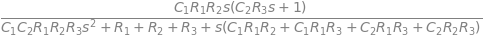

In [24]:
### OBSERVAMOS LAS CARACTERISTICAS DE NUESTRO CIRCUITO (FUNCIÓN DE TRANSFERENCIA Y RESPUESTA AL IMPULSO)

##GENERAMOS LA FUNCIÓN DE TRANSFERENCIA DEL CIRCUITO TOMANDO LA SALIDA EN R2
H=(ctt.R2.V(s)/ctt.Vi.V(s)).simplify()
H

In [25]:
#Dando valores al circuito:
C1=4.7e-4
C2=4.7e-4
R1=1000
R2=2000
R3=500
Coeficientes_num=[C1*C2*R1*R2*R3, C1*R1*R2] #Coeficientes numerador
Coeficientes_dem=[C1*C2*R1*R2*R3, C1*R1*R2 + C1*R1*R3 + C2*R1*R3 + C2*R2*R3, R1 + R2 + R3] #Coeficientes denominador

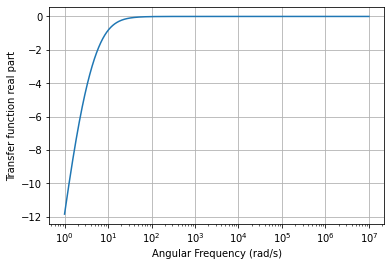

In [26]:
### LE ASIGNAMOS LOS VALORES A NUESTRA FUNCIÓN DE TRANSFERENCIA PARA VER EL COMPORTAMIENTO DEL CIRCUITO
### ASOCIADO A LOS PARAMETROS:
H_valores=H.subs("C1",C1).subs("C2",C2).subs("R1",R1).subs("R2",R2).subs("R3",R3)
W=logspace(0,7,2000) ## GENERAMOS VECTOR DE FRECUENCIAS EN ESCALA LOGARITMICA
X=H_valores(j*omega).dB.plot(W,log_frequency=True) ## GRAFICAMOS SEGUN UN VECTOR DE FRECUENCIAS

## FILTRO PASA ALTAS (IMPORTANTE)

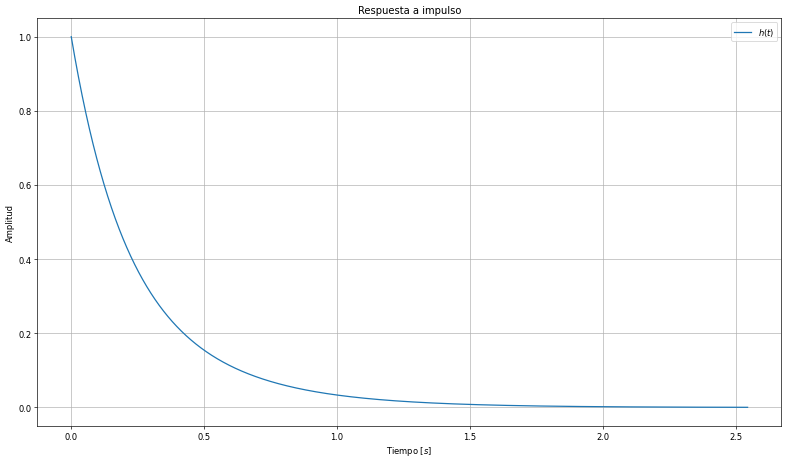

In [27]:
## AHORA ANALIZANDO LA RESPUESTA AL IMPULSO DEL SISTEMA, Y ASIGNANDO LOS VALORES AL MODELADO DEL CIRCUITO:
##OBSERVAMOS LA RESPUESTA AL IMPULSO:

lti_system = lti(Coeficientes_num, Coeficientes_dem)   #LTI
Nsample=4096 ## CANTIDAD DE MUESTRAS
t, h = lti_system.impulse(N=Nsample) # sistema LTI exitado con la función impulso
## NOS DEVUELVE 

plt.figure(figsize=(16, 9), dpi=60)
plt.plot(t, h, label='$h(t)$')

plt.grid(True)
plt.legend()
plt.title("Respuesta a impulso")
plt.xlabel("Tiempo [$s$]")
plt.ylabel("Amplitud")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


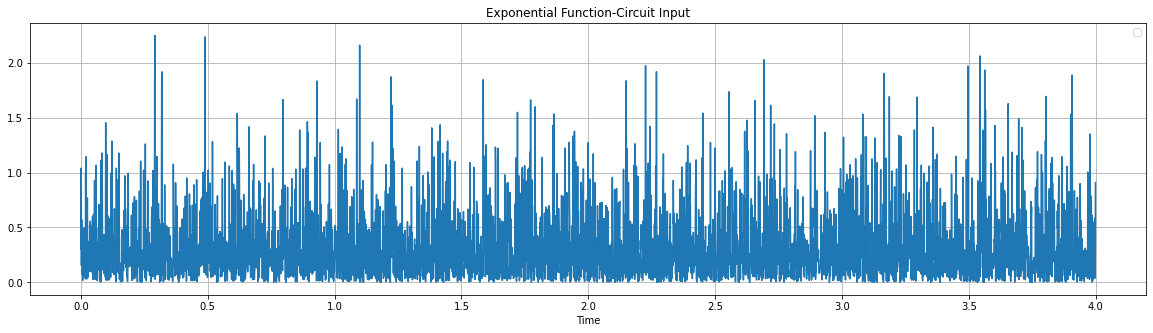

<Figure size 1440x360 with 0 Axes>

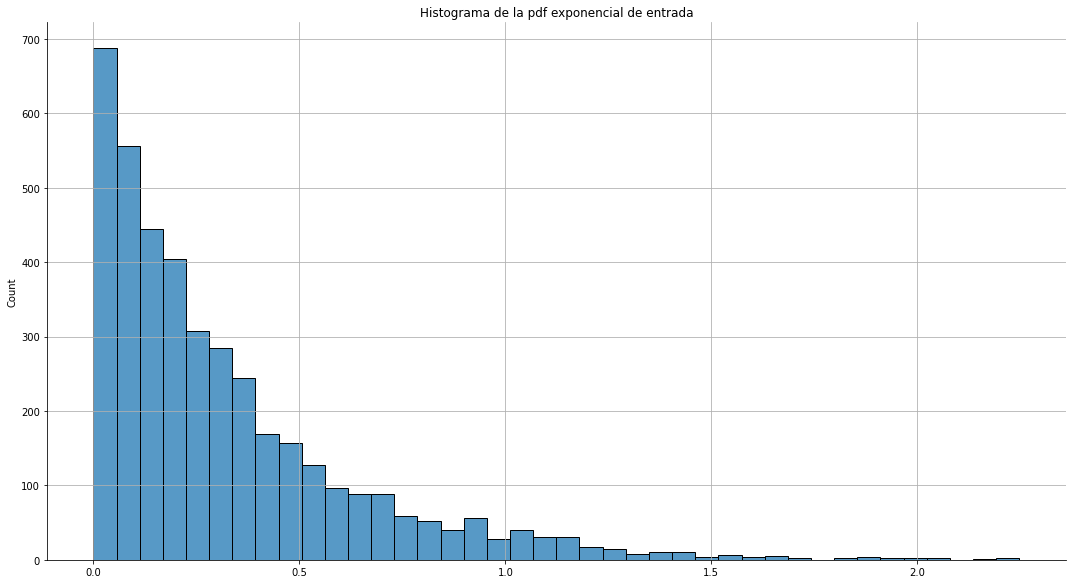

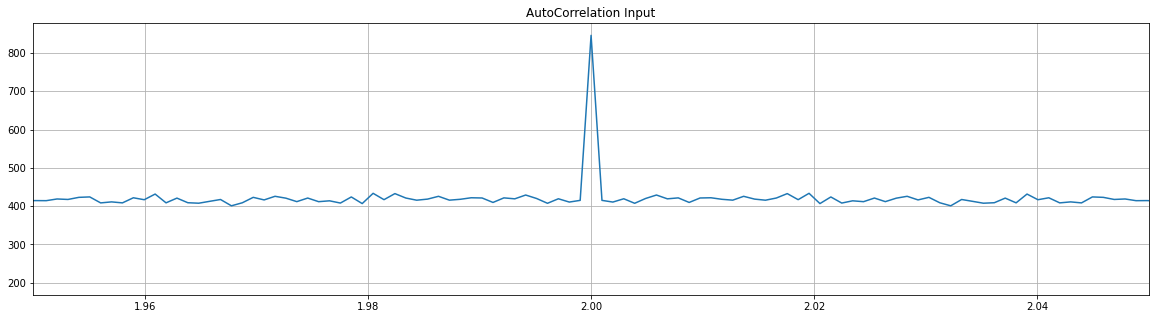

In [28]:
## GENERAMOS LA ENTRADA DE NUESTRO CIRCUITO:

Nbins=int((1+3.322*np.log2(Nsample)))### NUMERO DE BINS PARA EL HISTOGRAMA
Fdisc=Nsample/4 # FRECUENCIA DE MUESTREO
Tdisc=1/Fdisc
t=np.arange(0,4,Tdisc) ## GENERAMOS VECTOR DE TIEMPO PARA NUESTRA FUNCIÓN ALEATORIA

λ= np.pi     
expt= expon.rvs(loc=0,scale=1/λ,size=Nsample,random_state=None)
Autocorrelacion_expt=np.correlate(expt,expt,mode="same") ## GENERAMOS LA AUTOCORRELACION

plt.figure(figsize=(20,5))
plt.plot(t,expt)
plt.title("Exponential Function-Circuit Input")
plt.xlabel("Time")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
sns.displot(expt,bins=Nbins,height=8, aspect=15/8)
#sns.set(rc = {'figure.figsize':(20,5)})
hist_kws={"edgecolor":"balck"}
plt.title("Histograma de la pdf exponencial de entrada")
plt.grid()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(t,Autocorrelacion_expt)
plt.xlim(1.95,2.05)
hist_kws={"edgecolor":"balck"}
plt.title("AutoCorrelation Input")
plt.grid()
plt.show()






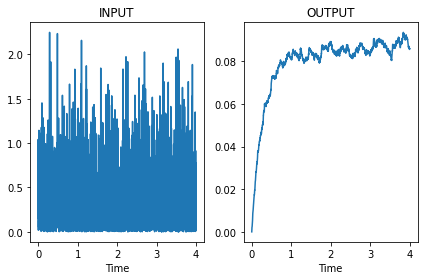

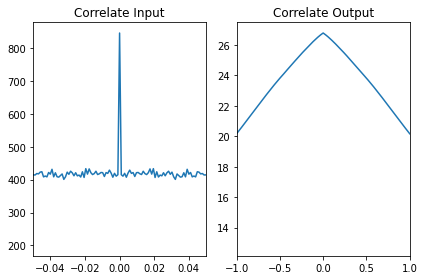

In [29]:
## INGRESAMOS LA ENTRADA EXPONENCIAL A NUESTRO CIRCUITO:
_,Output_Circuit,_=lti_system.output(expt, t) ##SALIDA DEL CIRCUITO.
Autocorrelacion_Output=np.correlate(Output_Circuit,Output_Circuit,mode="same") ## GENERAMOS LA AUTOCORRELACION
# COMPARAMOS ENTRADA VS SALIDA 
fig, axs = plt.subplots(1, 2)
axs[0].plot(t, expt)
axs[0].set_title("INPUT")
axs[0].set_xlabel("Time")
axs[1].plot(t, Output_Circuit)
axs[1].set_title("OUTPUT")
axs[1].set_xlabel("Time")


fig.tight_layout()

fig, axs = plt.subplots(1, 2)
axs[0].plot(t-2,Autocorrelacion_expt)
axs[0].set_title("Correlate Input")
axs[0].set_xlim(-0.05,0.05)
axs[1].plot(t-2, Autocorrelacion_Output)
axs[1].set_title("Correlate Output")
axs[1].set_xlim(-1,1)

fig.tight_layout()



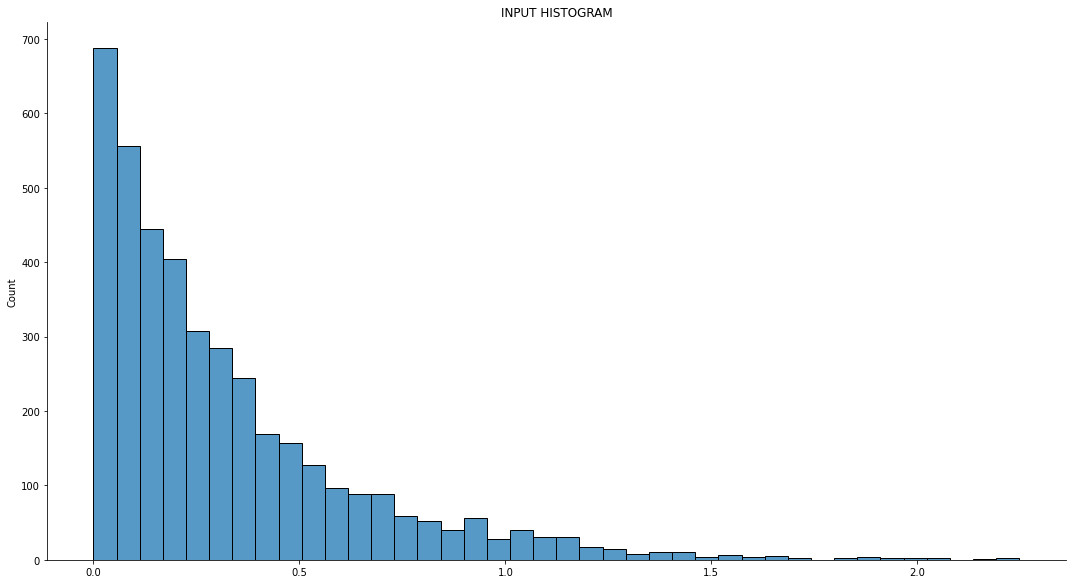

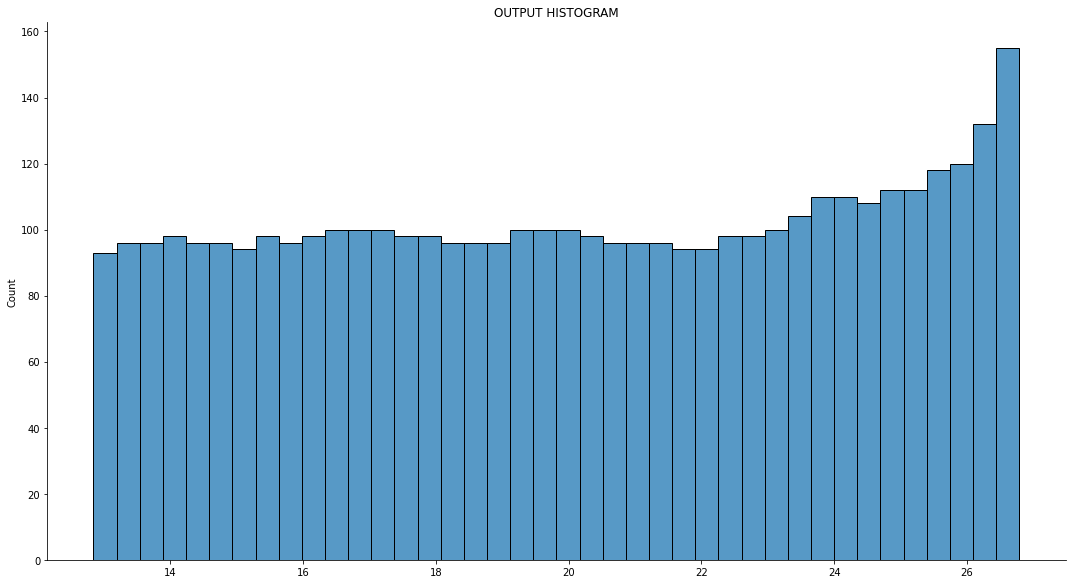

In [30]:
### COMPARANDO HISTOGRAMAS:


sns.displot(expt,bins=Nbins,height=8, aspect=15/8).set(title='INPUT HISTOGRAM')
sns.displot(Autocorrelacion_Output,bins=Nbins,height=8, aspect=15/8).set(title='OUTPUT HISTOGRAM')
plt.show()

In [ ]:
## GENERAMOS NUESTRA RED NEURONAL VAMOS A UTILIZAR UNA SIMPLE DE LA SIGUIENTE FORMA
### DEFINIMOS LA CANTIDAD DE NEURONAS POR CAPA
 
Nodos1 = 5
Nodos2 = 5
Nodos3 = 5

CAPA_ENTRADA=Dense(Nodos1 , activation='relu', input_dim=1)#  CREAMOS LA PRIMERA CAPA CON UNA SOLA ENTRADA QUE SERA
CAPA_OCULTA1=Dense(Nodos2, activation='relu', input_dim=Nodos1) ## CAPA OCULTA1
CAPA_OCULTA2=Dense(Nodos3, activation='relu', input_dim=Nodos2) ## CAPA OCULTA2
CAPA_SALIDA=Dense(1, activation='relu', input_dim=Nodos3) ## CAPA DE SALIDA QUE UNIFICA TODOS LOS NODOS
model=tf.keras.Sequential([CAPA_ENTRADA,CAPA_OCULTA1,CAPA_OCULTA2,CAPA_SALIDA]) ## MODELO SECUENCIAL, AGREGAMOS LAS CAPAS
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse') # Loss Function 
#model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate = 0.01))

In [ ]:
##SUBDIVIDMOS EL CONJUNTO DE ENTRADA

In [ ]:
"""
print("Comenzando entrenamiento...")
historial=model.fit(X_DATOS,Y_DATOS,epochs=1000,verbose=False) ##EPOCHS NUMERO DE VUELTAS QUE QUIERO QUE INTENTE 
print("Modelo entrenado")
"""

'\nprint("Comenzando entrenamiento...")\nhistorial=model.fit(X_DATOS,Y_DATOS,epochs=1000,verbose=False) ##EPOCHS NUMERO DE VUELTAS QUE QUIERO QUE INTENTE \nprint("Modelo entrenado")\n'